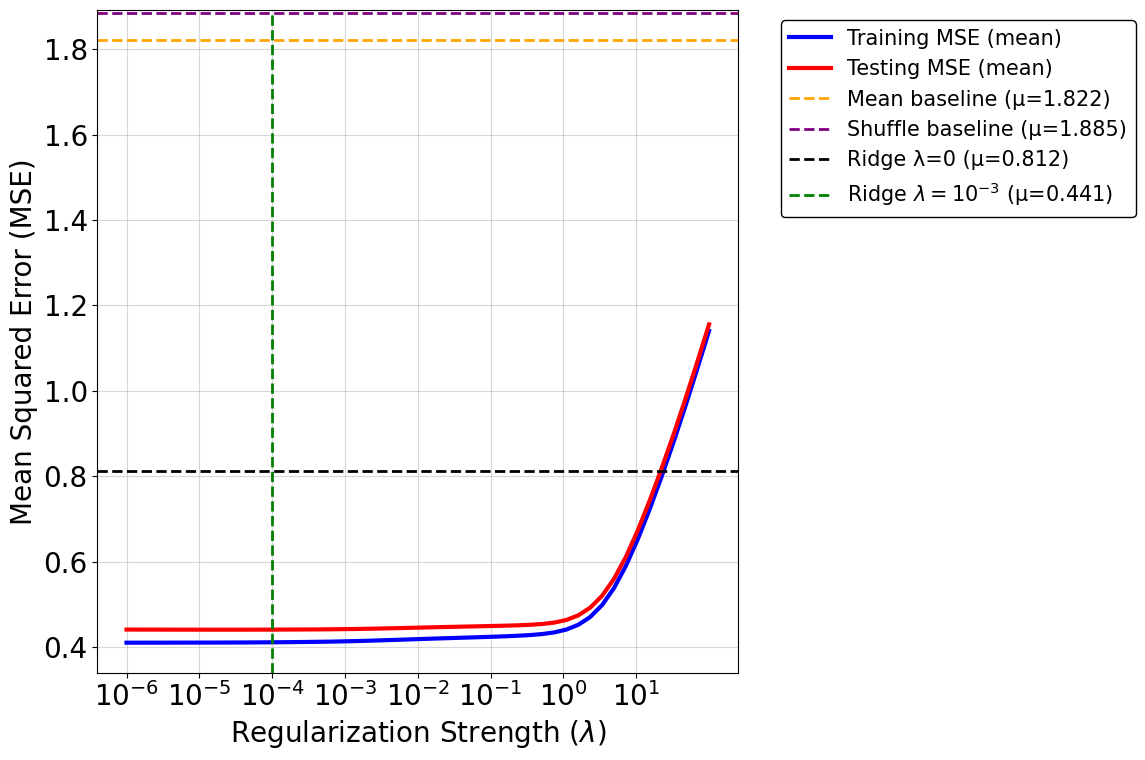

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.size'] = 20

energy = -np.loadtxt("ATF4_exp_ddg.txt")
phi = np.loadtxt("ATF4_phi_summary.txt")

alphas = np.logspace(-6, 2, 50)
num_seeds = 50

train_mse_all = np.zeros((num_seeds, len(alphas)))
test_mse_all = np.zeros((num_seeds, len(alphas)))
best_alphas = []

mean_baseline_all = np.zeros(num_seeds)
shuffle_baseline_all = np.zeros(num_seeds)
ridge0_baseline_all = np.zeros(num_seeds)

for i, seed in enumerate(range(num_seeds)):
    X_train, X_test, y_train, y_test = train_test_split(phi, energy, test_size=0.2, random_state=seed)

    ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
    ridge_cv.fit(X_train, y_train)
    best_alphas.append(ridge_cv.alpha_)

    # baseline 1: mean predictor
    y_mean = np.full_like(y_test, y_train.mean())
    mean_baseline_all[i] = mean_squared_error(y_test, y_mean)

    # baseline 2: ridge λ=0
    ridge0 = Ridge(alpha=0)
    ridge0.fit(X_train, y_train)
    ridge0_baseline_all[i] = mean_squared_error(y_test, ridge0.predict(X_test))

    # baseline 3: shuffle baseline
    idx = np.random.permutation(len(y_train))
    ridge_shuffle = Ridge(alpha=ridge_cv.alpha_)
    ridge_shuffle.fit(X_train, y_train[idx])
    shuffle_baseline_all[i] = mean_squared_error(y_test, ridge_shuffle.predict(X_test))

    for j, alpha in enumerate(alphas):
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train, y_train)
        y_train_pred = ridge.predict(X_train)
        y_test_pred = ridge.predict(X_test)
        train_mse_all[i, j] = mean_squared_error(y_train, y_train_pred)
        test_mse_all[i, j] = mean_squared_error(y_test, y_test_pred)

train_mse_mean = np.mean(train_mse_all, axis=0)
test_mse_mean = np.mean(test_mse_all, axis=0)

mean_baseline_mu = mean_baseline_all.mean()
shuffle_baseline_mu = shuffle_baseline_all.mean()
ridge0_baseline_mu = ridge0_baseline_all.mean()

mean_best_alpha = np.median(best_alphas)

plt.figure(figsize=(12, 8))

plt.semilogx(alphas, train_mse_mean, 'b-', label='Training MSE (mean)', linewidth=3)
plt.semilogx(alphas, test_mse_mean,  'r-', label='Testing MSE (mean)',  linewidth=3)

plt.axhline(mean_baseline_mu,    color='orange', linestyle='--', linewidth=2,
            label=f'Mean baseline (μ={mean_baseline_mu:.3f})')
plt.axhline(shuffle_baseline_mu, color='purple', linestyle='--', linewidth=2,
            label=f'Shuffle baseline (μ={shuffle_baseline_mu:.3f})')
plt.axhline(ridge0_baseline_mu,  color='black',  linestyle='--',  linewidth=2,
            label=f'Ridge λ=0 (μ={ridge0_baseline_mu:.3f})')

lambda_ref = 1e-4

ref_mse = np.interp(lambda_ref, alphas, test_mse_mean)
plt.axvline(lambda_ref, color='green', linestyle='--', linewidth=2,
            label=r'Ridge $\lambda = 10^{-3}$ (μ=0.441)')


plt.xlabel(r'Regularization Strength ($\lambda$)')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1],
           [r'$10^{-6}$', r'$10^{-5}$', r'$10^{-4}$', r'$10^{-3}$',
            r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$',  r'$10^{1}$'])
plt.grid(True, alpha=0.5)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
           frameon=True, edgecolor='black', framealpha=1.0, facecolor='white', fontsize=15)

plt.tight_layout()
# plt.savefig("ridge_lambda_mse_avg100_with_refline.pdf", bbox_inches='tight')
plt.show()

# print(f"Median of best λ from 100 seeds = {mean_best_alpha:.6f}")
# print(f"Mean baseline MSE   = {mean_baseline_mu:.4f}")
# print(f"Shuffle baseline MSE= {shuffle_baseline_mu:.4f}")
# print(f"Ridge λ=0 MSE       = {ridge0_baseline_mu:.4f}")


In [7]:
import numpy as np
from sklearn.linear_model import RidgeCV

energy = -np.loadtxt("ATF4_exp_ddg.txt")
phi = np.loadtxt("ATF4_phi_summary.txt")

alphas = np.logspace(-4, 2, 50) 

ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(phi, energy)

# print("best alpha =", ridge_cv.alpha_)
gamma_ridge = ridge_cv.coef_

np.savetxt("ATF4_gamma_SELEX_refined.txt", gamma_ridge, fmt="%.6f")